In [84]:
import pandas as pd 
import numpy as np
import os
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
import cv2 as cv
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import feature
from preprocessing import *


In [85]:
data = []

labels = {}

folders = os.listdir()
for i,value in enumerate(folders): 
    if os.path.isdir(value) and not value.startswith('.'):
        labels[i] = value
        files = os.listdir(value)
        for j in files:
            data.append({'Image': os.path.join(value, j), 'Label': i} )

df = pd.DataFrame(data)

print(labels)

df.head()

{3: 'IBM Plex Sans Arabic preprocessed', 4: 'Lemonada preprocessed', 5: 'Marhey preprocessed', 9: 'Scheherazade New preprocessed'}


,Image,Label
0,IBM Plex Sans Arabic preprocessed\0.jpeg,3
1,IBM Plex Sans Arabic preprocessed\1.jpeg,3
2,IBM Plex Sans Arabic preprocessed\10.jpeg,3
3,IBM Plex Sans Arabic preprocessed\100.jpeg,3
4,IBM Plex Sans Arabic preprocessed\101.jpeg,3


In [86]:
# Use SIFT instead of ORB
sift = cv.SIFT_create()

def SIFT(image):
    max_keypoints = 100 
    max_descriptors_per_keypoint = 50
    if image is None:
        print("No image!!")
        return np.zeros(50000)

    kp, des = sift.detectAndCompute(image, None)
    
    # Check if descriptors are found
    if des is None:
        return [0] * (max_keypoints * max_descriptors_per_keypoint)  # Return zero descriptors
    
    if len(kp) > max_keypoints:
        # Sort keypoints by response and select the top ones
        sorted_indices = sorted(range(len(kp)), key=lambda i: kp[i].response, reverse=True)
        selected_indices = sorted_indices[:max_keypoints]
        kp = [kp[i] for i in selected_indices]
        des = [des[i] for i in selected_indices]
    
    # Truncate descriptors if more than max_descriptors_per_keypoint
    truncated_descriptors = []
    for d in des:
        if len(d) > max_descriptors_per_keypoint:
            truncated_descriptors.append(d[:max_descriptors_per_keypoint])
        else:
            truncated_descriptors.append(d)
    
    # Flatten list of descriptors
    flattened_descriptors = [item for sublist in truncated_descriptors for item in sublist]
    
    # Pad with zeros if the number of descriptors is less than required
    if len(flattened_descriptors) < max_keypoints * max_descriptors_per_keypoint:
        flattened_descriptors.extend([0] * (max_keypoints * max_descriptors_per_keypoint - len(flattened_descriptors)))
    
    return flattened_descriptors[:max_keypoints * max_descriptors_per_keypoint]

In [87]:

def horizontal_profile_projection(image):
    # Compute vertical histogram
    histogram = np.sum(image, axis=1)
    
    # Normalize histogram
    max_value = np.max(histogram)
    
    if(max_value == 0):
        return 0
    
    normalized_histogram = histogram / max_value
    
    # Compute HPP
    HPP = np.sum(normalized_histogram) / max_value
    
    return HPP

def vertical_profile_projection(image):

    # Compute horizontal histogram
    histogram = np.sum(image, axis=0)

    # Normalize histogram
    max_value = np.max(histogram)
    if max_value == 0:
        return 0

    normalized_histogram = histogram / max_value

    # Compute vertical profile projection
    VPP = np.sum(normalized_histogram) / max_value

    return VPP


def haralick_texture_features(image):
    # Compute GLCM
    distances = [1]  # You can adjust the distances as needed
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]  # You can adjust the angles as needed
    glcm = feature.graycomatrix(image, distances=distances, angles=angles, symmetric=True, normed=True)

    # Compute Haralick texture features
    haralick_features = feature.graycoprops(glcm)

    return haralick_features


In [88]:

def precompute_gabor_kernels(ksize, sigma, lambd, gamma, psi):
    gabor_kernels = {}
    for theta in [0 , np.pi / 8.0]:
        for freq in lambd:
            gabor_kernel = cv.getGaborKernel((ksize, ksize), sigma, theta, freq, gamma, psi)
            gabor_kernels[(theta, freq)] = gabor_kernel
    return gabor_kernels


def feature_extraction(img_path):
    ksize = 31
    sigma = 1.5
    lambd = [0.1,0.5,1, 4, 8]        #90.6% #[0.3, 4] => 90.2% accuracy
    gamma = 0.5
    psi = 0

    # Precompute Gabor Kernels
    gabor_kernels = precompute_gabor_kernels(ksize, sigma, lambd, gamma, psi)

    # Read and preprocess image
    image = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    
    # image = cv.resize(image, (256, 256))
    # _, image = cv.threshold(image, 127, 255, cv.THRESH_BINARY)
    # image = preprocess_image(img_path,256)
    
    
    feature_vecotr = []
    for gabor_kernel in gabor_kernels.values():
        # Apply Gabor filter
        filtered_image = cv.filter2D(image, cv.CV_64F, gabor_kernel)

        # Calculate mean and standard deviation using numpy operations
        mean_val = np.mean(filtered_image)
        std_val = np.std(filtered_image)

        # Append to feature_vecotr
        feature_vecotr.extend([mean_val, std_val])
        
    
    
    dft = cv.dft(np.float32(image), flags=cv.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    # Define passband cutoff frequencies
    # passband_lower_cutoff = [0, 36, 72, 108, 144, 180, 216]
    # passband_upper_cutoff = [41, 77, 113, 149, 185, 221, 255]
    
    passband_lower_cutoff = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225]
    passband_upper_cutoff = [30, 55, 80, 105, 130, 155, 180, 205, 230, 255]

    

    
    # Create a passband filter in the frequency domain
    rows, cols = dft_shift.shape[0], dft_shift.shape[1]
    crow, ccol = rows // 2, cols // 2
    

 
    for i,lower_cutoff in enumerate(passband_lower_cutoff):
        mask = np.zeros((rows, cols, 2), np.uint8)
        mask[crow - int(passband_upper_cutoff[i]):crow + int(passband_upper_cutoff[i]), 
            ccol - int(passband_upper_cutoff[i]):ccol + int(passband_upper_cutoff[i])] = 1
        mask[crow - int(passband_lower_cutoff[i]):crow + int(passband_lower_cutoff[i]), 
            ccol - int(passband_lower_cutoff[i]):ccol + int(passband_lower_cutoff[i])] = 0  
        filtered_dft = dft_shift * mask
        magnitude_spectrum = 20 * np.log(cv.magnitude(filtered_dft[:, :, 0], filtered_dft[:, :, 1]) + 1e-10)
        mean = np.mean(magnitude_spectrum)
        std = np.std(magnitude_spectrum)
        feature_vecotr.extend([mean, std])


    # Compute HPP
    # HPP = horizontal_profile_projection(image)
    # feature_vecotr.extend([HPP])
    
    # compute VPP
    # VPP = vertical_profile_projection(image)
    # feature_vecotr.extend([VPP])
    # 
    
    # Compute Haralick texture feature_vecotr
    # haralick_features = haralick_texture_features(image)
    # feature_vecotr.extend(haralick_features.flatten())
    
    # descriptors = SIFT(image)
    # feature_vecotr.extend(descriptors)
    
    return feature_vecotr



x = pd.DataFrame(df['Image'].apply(feature_extraction))
x.head()


,Image
0,"[25.05738791724787, 139.5364111367434, 25.0573..."
1,"[539.1857770770521, 945.1085633807277, 539.185..."
2,"[718.8480944116085, 951.4853745179563, 718.848..."
3,"[355.56607172044994, 339.2275538120744, 355.56..."
4,"[853.4257519320319, 1417.3866056122486, 853.42..."


In [89]:
x = pd.DataFrame(x['Image'].to_list(), columns=['Feature'+str(i) for i in range(1, len(x['Image'][0])+1)])
df = pd.concat([df, x], axis=1) 

In [90]:
df.drop('Image', axis=1, inplace=True)
df.head()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['Label']))
pca = PCA(n_components=16)
X_pca = pca.fit_transform(X_scaled)



In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, df['Label'], test_size=0.2, random_state=42)

In [92]:
X = X_pca
y= df['Label']
clf = RandomForestClassifier(n_estimators=1000, random_state=42 , n_jobs=-1)

# Train the classifier on the training data
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

In [93]:
y_pred = clf.predict(X_test)
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9325


### Cross validation on the test-set

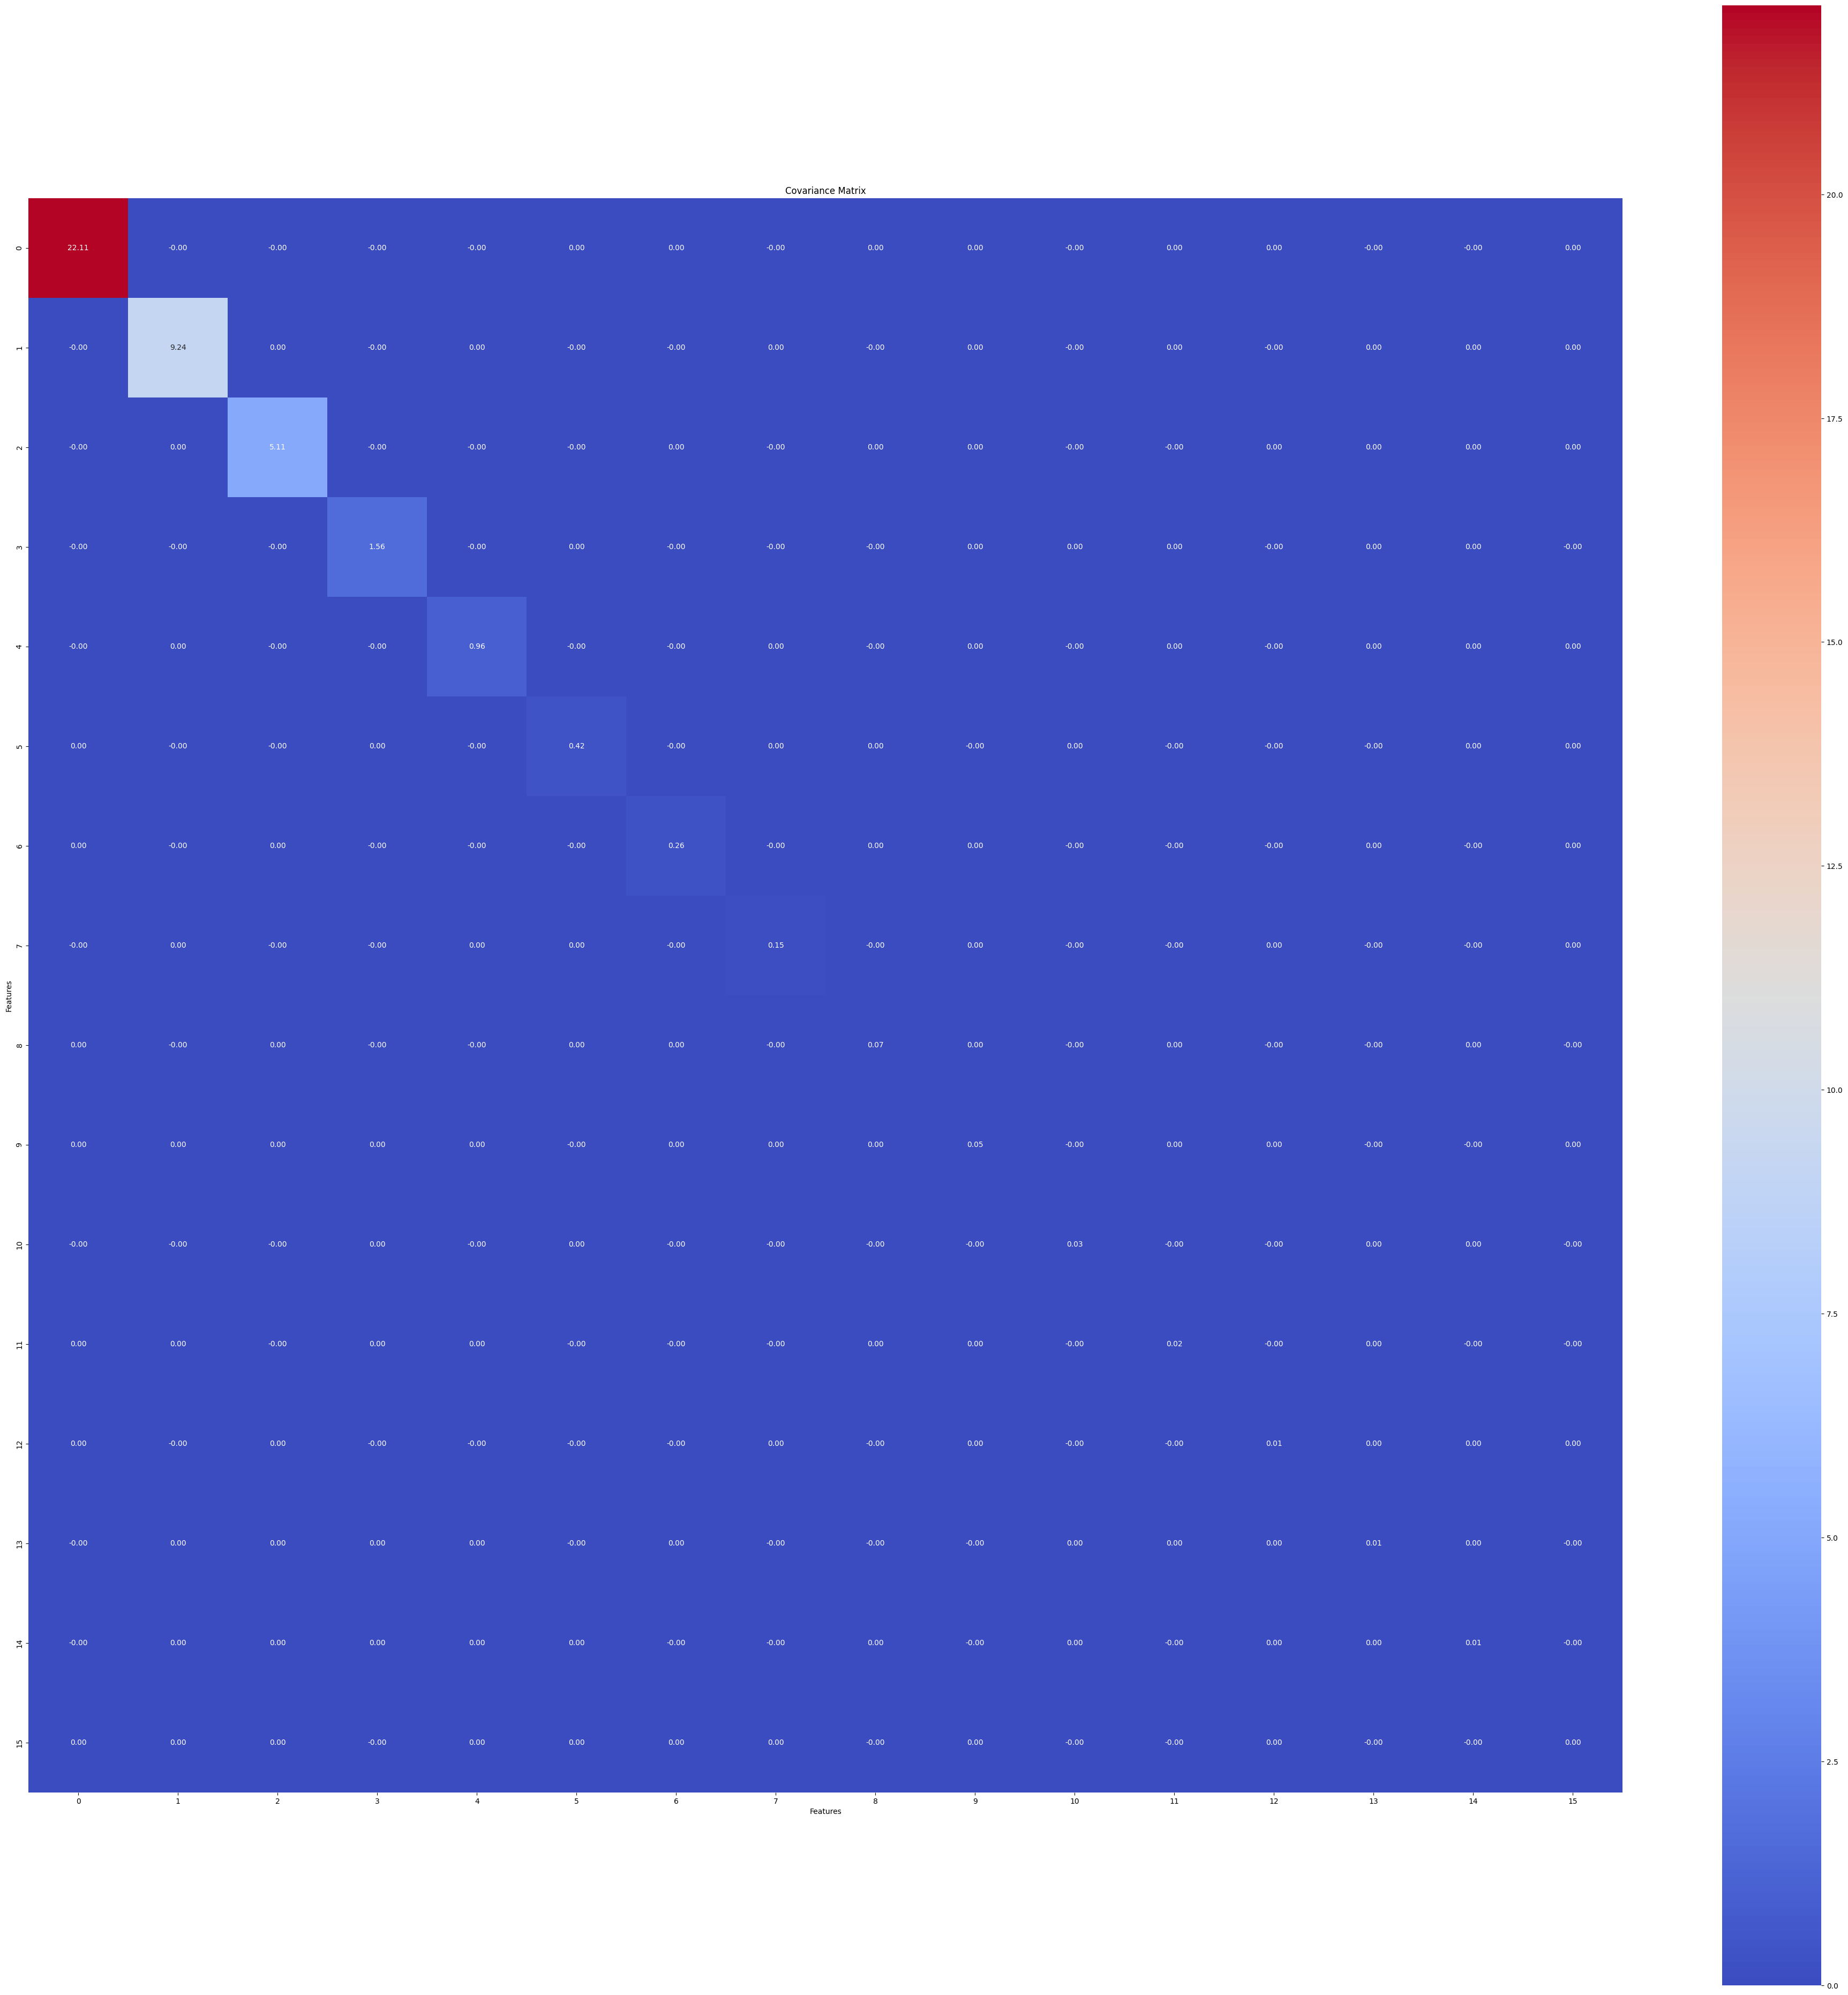

In [94]:
cov_matrix = np.cov(X, rowvar=False) 

plt.figure(figsize=(48, 48))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Covariance Matrix')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [95]:
clf = RandomForestClassifier(n_estimators=1000, random_state=42 , n_jobs=-1)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
Score = cross_val_score(clf, X, y, cv=cv)
print(Score)

[0.935   0.92125 0.92875 0.90875 0.93375]
